In [1]:
import os, urllib.request, zipfile
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from plot_util import plot_history

Using TensorFlow backend.


In [2]:
IMDB_DIR = './data/aclImdb'
TRAIN_DIR = os.path.join(IMDB_DIR, 'train')
GLOVE_DIR = './data/glove.6B'

MAXLEN = 100
TRAIN_SAMPLES = 200
VAL_SAMPLES = 10000
MAX_WORDS = 10000

EMBEDDING_DIM = 100

In [3]:
if not os.path.isdir(IMDB_DIR):
    IMDB_ZIP_PATH = './data/aclImdb.zip'
    if not os.path.isfile(IMDB_ZIP_PATH):
        urllib.request.urlretrieve ('http://s3.amazonaws.com/text-datasets/aclImdb.zip', IMDB_ZIP_PATH)
    zip_file = zipfile.ZipFile(IMDB_ZIP_PATH, 'r')
    zip_file.extractall('./data')
    zip_file.close()
    
if not os.path.isdir(GLOVE_DIR):
    GLOVE_ZIP_PATH = './data/glove.6B.zip'
    if not os.path.isfile(GLOVE_ZIP_PATH):
        urllib.request.urlretrieve ('https://nlp.stanford.edu/data/glove.6B.zip', GLOVE_ZIP_PATH)
    zip_file = zipfile.ZipFile(GLOVE_ZIP_PATH, 'r')
    zip_file.extractall(GLOVE_DIR)
    zip_file.close()

In [4]:
labels = []
texts = []

for label in ['neg', 'pos']:
    file_dir = os.path.join(TRAIN_DIR, label)
    for file_name in os.listdir(file_dir):
        if file_name.lower().endswith('.txt'):
            file_path = os.path.join(file_dir, file_name)
            with open(file_path) as f:
                texts.append(f.read())
            labels.append(0 if label == 'neg' else 1)

print("len(texts) = {}".format(len(texts)))
print("sample text: {}".format(texts[0]))
print("sample label: {}".format(labels[0]))

len(texts) = 25000
sample text: This is the worst imaginable crap. The novel by H. Rider Haggard is very entertaining and dramatic. The makers of this worthless movie don't follow it closely. Well, old novels aren't sacred and making free versions of them is fine with me if one has ideas of one's own. If all one can do is changing things and replace them with uninteresting and watered-down clichés one should stick to the original. If they had done that this film would have been at least twice as good even with worse actors and if filmed inside a studio with huts made of cardboard. BUt there's no imagination at all only tiredness. This should be bought or watched only by collectors of Victorian novels made into movies.<br /><br />Just a hint, and not a spoiler I think, to make those of you who have read the novel understand what has taken place and what you may expect if you decide to watch this on TV or - God forbid - waste money on buying this. Gagool an old baddie witch in the book a

In [5]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
print("len(sequences) = {}".format(len(sequences)))
print("sample sequence = {}".format(sequences[0]))

word_index = tokenizer.word_index
print("len(word_index) = {}".format(len(word_index)))

len(sequences) = 25000
sample sequence = [11, 6, 1, 246, 5340, 592, 1, 664, 31, 2016, 6627, 6, 52, 438, 2, 901, 1, 1184, 4, 11, 3537, 17, 89, 790, 9, 3264, 70, 151, 2863, 710, 9654, 2, 228, 875, 2052, 4, 95, 6, 475, 16, 69, 44, 28, 45, 1005, 4, 2058, 202, 44, 29, 28, 67, 78, 6, 2537, 180, 2, 5171, 95, 16, 2497, 2, 9092, 177, 1802, 28, 141, 1226, 5, 1, 201, 44, 33, 66, 221, 12, 11, 19, 59, 25, 74, 30, 219, 1448, 14, 49, 57, 16, 430, 153, 2, 44, 811, 1001, 3, 1177, 16, 90, 4, 3432, 18, 222, 54, 1542, 30, 29, 61, 11, 141, 27, 1244, 39, 293, 61, 31, 4, 6354, 2863, 90, 80, 99, 7, 7, 40, 3, 3146, 2, 21, 3, 1357, 10, 101, 5, 94, 145, 4, 22, 34, 25, 329, 1, 664, 388, 48, 45, 620, 270, 2, 48, 22, 200, 532, 44, 22, 1194, 5, 103, 11, 20, 245, 39, 555, 434, 275, 20, 2640, 11, 32, 151, 8422, 1714, 8, 1, 271, 2, 46, 5, 45, 74, 676, 80, 3, 324, 5558]
len(word_index) = 88582


In [6]:
data_x = pad_sequences(sequences, maxlen=MAXLEN)
data_y = np.asarray(labels)
print("data_x.shape = {}".format(data_x.shape))
print("data_y.shape = {}".format(data_y.shape))

data_x.shape = (25000, 100)
data_y.shape = (25000,)


In [7]:
indices = np.arange(data_x.shape[0])
np.random.shuffle(indices)
data_x = data_x[indices]
data_y = data_y[indices]

In [8]:
train_x = data_x[:TRAIN_SAMPLES]
train_y = data_y[:TRAIN_SAMPLES]
val_x = data_x[TRAIN_SAMPLES:(TRAIN_SAMPLES + VAL_SAMPLES)]
val_y = data_y[TRAIN_SAMPLES:(TRAIN_SAMPLES + VAL_SAMPLES)]
print("train_x.shape = {}, train_y.shape = {}".format(train_x.shape, train_y.shape))
print("val_x.shape = {}, val_y.shape = {}".format(val_x.shape, val_y.shape))

train_x.shape = (200, 100), train_y.shape = (200,)
val_x.shape = (10000, 100), val_y.shape = (10000,)


In [9]:
embeddings_index = {}

with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("len(embeddings_index) = {}".format(len(embeddings_index)))
print("embeddings_index['the'] = \n{}".format(embeddings_index['the']))
print("embeddings_index['the'].shape = {}".format(embeddings_index['the'].shape))

len(embeddings_index) = 400000
embeddings_index['the'] = 
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -

In [10]:
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
print("embedding_matrix.shape = {}".format(embedding_matrix.shape))

embedding_matrix.shape = (10000, 100)


## Training with GloVe word embeddings

In [11]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAXLEN))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [12]:
history_with_glove = model.fit(
    train_x, train_y, epochs=10, batch_size=32,
    validation_data=(val_x, val_y),
    verbose=2
)

Instructions for updating:
Use tf.cast instead.
Train on 200 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 2.9523 - acc: 0.4850 - val_loss: 0.7074 - val_acc: 0.5141
Epoch 2/10
 - 0s - loss: 0.6243 - acc: 0.6350 - val_loss: 0.7875 - val_acc: 0.5030
Epoch 3/10
 - 0s - loss: 0.4580 - acc: 0.8200 - val_loss: 0.8649 - val_acc: 0.5113
Epoch 4/10
 - 0s - loss: 0.4035 - acc: 0.8050 - val_loss: 0.7147 - val_acc: 0.5581
Epoch 5/10
 - 0s - loss: 0.4006 - acc: 0.8100 - val_loss: 0.7178 - val_acc: 0.5734
Epoch 6/10
 - 0s - loss: 0.1660 - acc: 0.9900 - val_loss: 0.9750 - val_acc: 0.5244
Epoch 7/10
 - 0s - loss: 0.1400 - acc: 0.9550 - val_loss: 2.1586 - val_acc: 0.4983
Epoch 8/10
 - 0s - loss: 0.1918 - acc: 0.9300 - val_loss: 0.7203 - val_acc: 0.6030
Epoch 9/10
 - 0s - loss: 0.0429 - acc: 1.0000 - val_loss: 0.9257 - val_acc: 0.5594
Epoch 10/10
 - 0s - loss: 0.1860 - acc: 0.9150 - val_loss: 0.7626 - val_acc: 0.5842


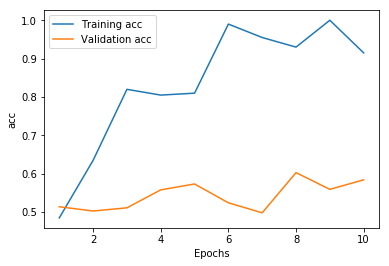

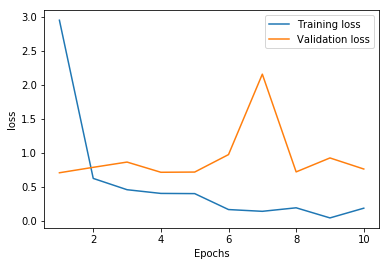

In [13]:
plot_history(history_with_glove, metrics=('acc', 'loss'))

## Training without pretrained word embeddings

In [14]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAXLEN))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_without_glove = model.fit(
    train_x, train_y, epochs=10, batch_size=32,
    validation_data=(val_x, val_y),
    verbose=2
)

Train on 200 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 0.6935 - acc: 0.5250 - val_loss: 0.6939 - val_acc: 0.5044
Epoch 2/10
 - 0s - loss: 0.5325 - acc: 0.9800 - val_loss: 0.6925 - val_acc: 0.5210
Epoch 3/10
 - 0s - loss: 0.3151 - acc: 1.0000 - val_loss: 0.6919 - val_acc: 0.5296
Epoch 4/10
 - 0s - loss: 0.1455 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.5378
Epoch 5/10
 - 0s - loss: 0.0682 - acc: 1.0000 - val_loss: 0.7002 - val_acc: 0.5342
Epoch 6/10
 - 0s - loss: 0.0350 - acc: 1.0000 - val_loss: 0.7038 - val_acc: 0.5352
Epoch 7/10
 - 0s - loss: 0.0192 - acc: 1.0000 - val_loss: 0.7110 - val_acc: 0.5421
Epoch 8/10
 - 0s - loss: 0.0110 - acc: 1.0000 - val_loss: 0.7161 - val_acc: 0.5420
Epoch 9/10
 - 0s - loss: 0.0064 - acc: 1.0000 - val_loss: 0.7227 - val_acc: 0.5364
Epoch 10/10
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.7290 - val_acc: 0.5459


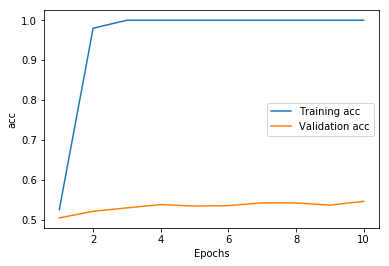

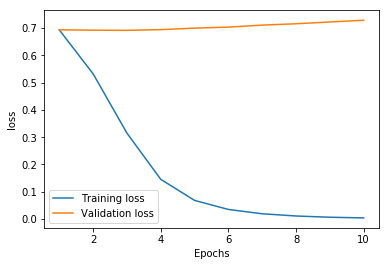

In [16]:
plot_history(history_without_glove, metrics=('acc', 'loss'))